In [8]:
import os
import time
import glob
import itertools as it
import numpy as np
import cv2
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%run Functions.py

In [9]:
#load data from trainer
cls_dict = pickle.load(open("classifier_LinearSVC_YCrCb_991_HogALL.p", "rb"))

# Pull in parameters and classifier from dictionary
color_space = cls_dict['color_space']
orient = cls_dict['orient']
pix_per_cell = cls_dict['pix_per_cell']
cell_per_block = cls_dict['cell_per_block']
hog_channel = cls_dict['hog_channel']
spatial_size = cls_dict['spatial_size']
hist_bins = cls_dict['hist_bins']
spatial_feat = cls_dict['spatial_feat']
hist_feat = cls_dict['hist_feat']
hog_feat = cls_dict['hog_feat']
y_start_stop = cls_dict['y_start_stop']
ystart = y_start_stop[0]
ystop = y_start_stop[1]
svc = cls_dict['svc']
X_scaler = cls_dict['X_scaler']
print(cls_dict)
#scale = 1.5
scale = [1.1, 1.5, 1.9, 2.3]
heat_frames=5
confidence_threshold = 0.3
heat_threshold = 3
heat_smooth_factor = 0
heat_list=[]

{'spatial_size': (32, 32), 'color_space': 'YCrCb', 'cell_per_block': 2, 'hog_feat': True, 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'y_start_stop': [400, 656], 'hog_channel': 'ALL', 'hist_bins': 32, 'spatial_feat': True, 'hist_feat': True, 'orient': 32, 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'pix_per_cell': 16}


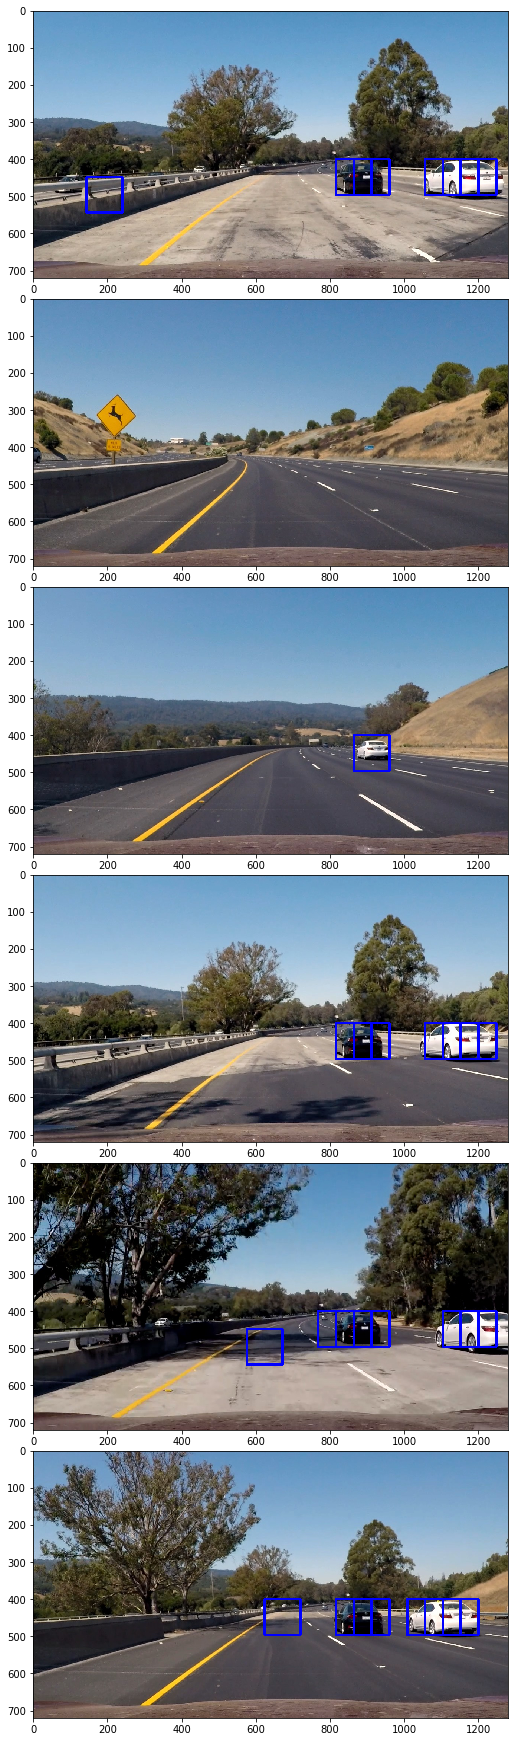

In [10]:
path = 'test_images/*.jp*'
example_images = glob.glob(path)
#print(len(example_images))

images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5

row = len(example_images)
plt.figure(figsize=(10,4*row))
for i, example in enumerate(example_images):
    t1 = time.time()
    img = mpimg.imread(example)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(96, 96), xy_overlap=(overlap, overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    plt.subplot(row, 1, i+1)
    plt.imshow(window_img)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

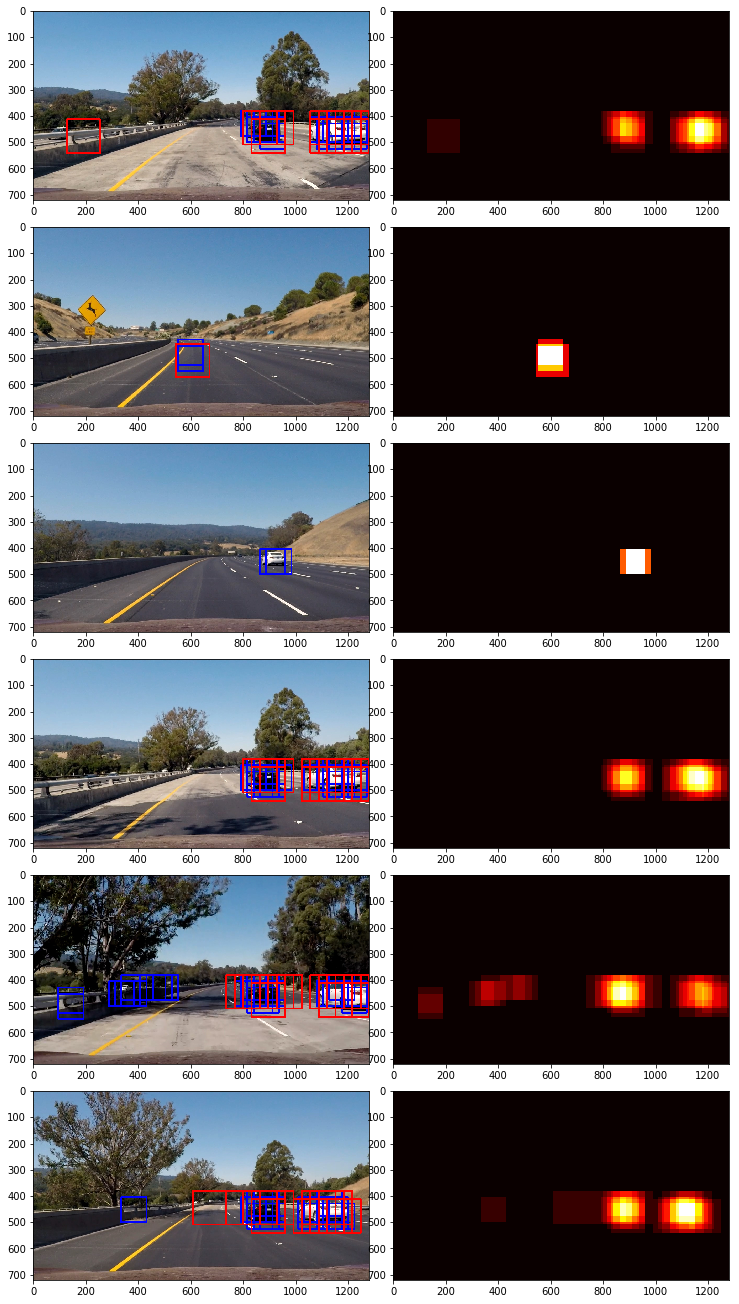

In [11]:
ystart = 380
ystop = 720
xstart = 0
row = len(example_images)
plt.figure(figsize=(10,3*row))
for i, example in enumerate(example_images):
    t1 = time.time()
    img = mpimg.imread(example)
    scale = 1.5
    out_img, heat_map1, img_boxes1, count1 = find_cars(img, ystart, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)
    scale = 2
    out_img, heat_map2, img_boxes2, count2 = find_cars(img, ystart, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)
    heat_map = heat_map1 + heat_map2
    #img_boxes = img_boxes1 + img_boxes2
    window_img = draw_boxes(img, img_boxes1, color=(0,0,255), thick=6)
    window_img = draw_boxes(window_img, img_boxes2, color=(255,0,0), thick=6)
    plt.subplot(row, 2, i*2+1)
    plt.imshow(window_img)
    plt.subplot(row, 2, i*2+2)
    plt.imshow(heat_map, cmap='hot')
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

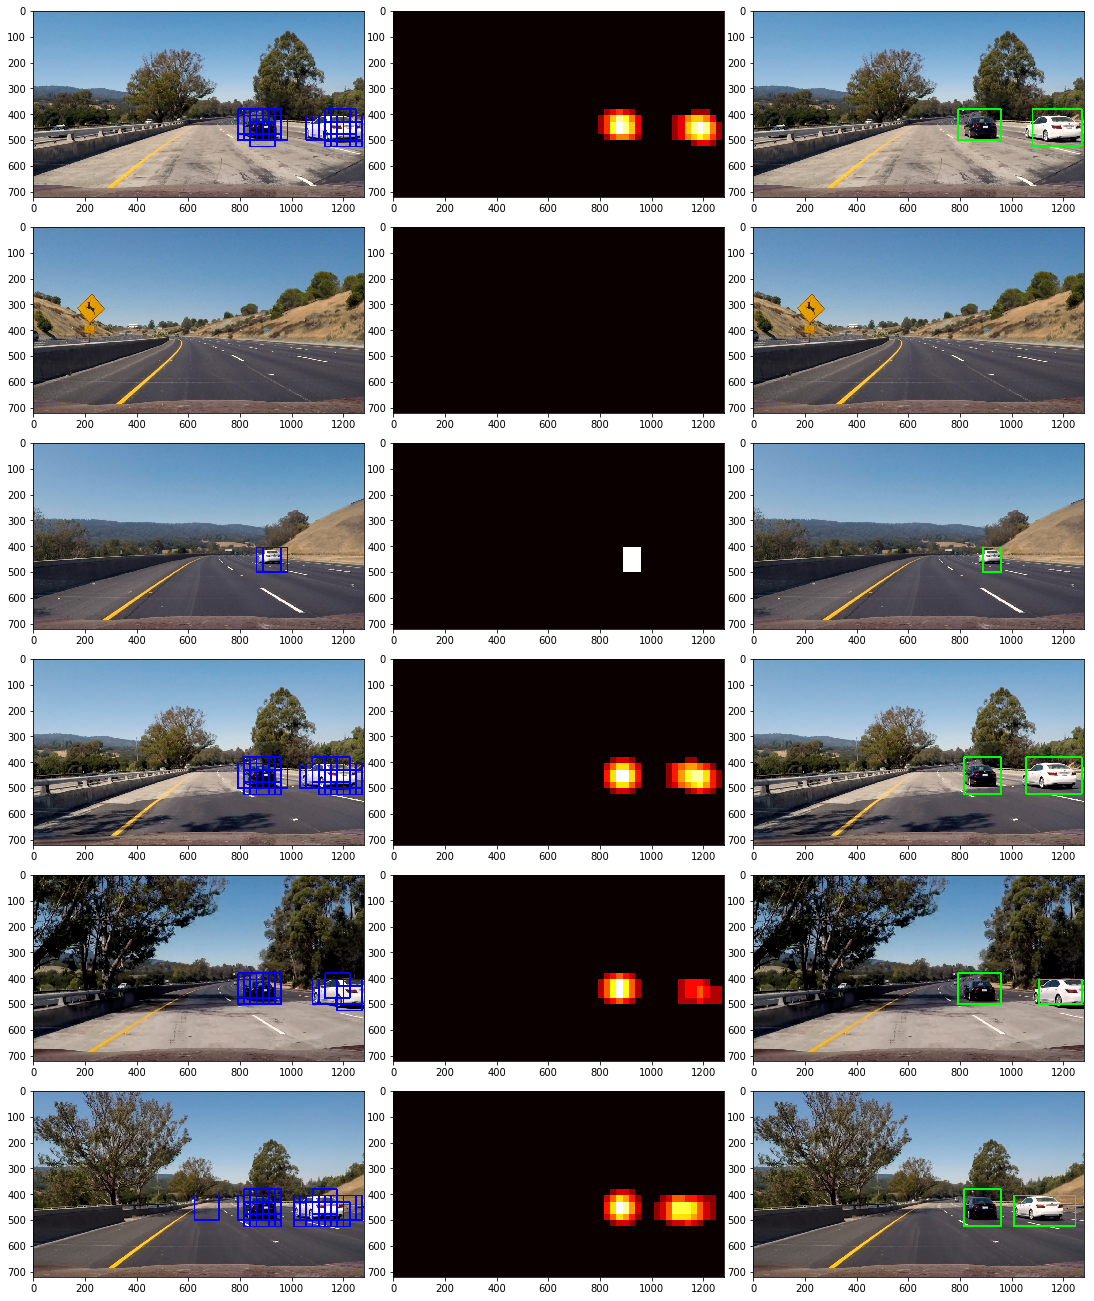

In [12]:
xstart = 600
row = len(example_images)
plt.figure(figsize=(15,3*row))
for i, example in enumerate(example_images):
    t1 = time.time()
    img = mpimg.imread(example)
    scale = 1.5
    _, heat_map1, windows1, count1 = find_cars(img, ystart, 600, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)
    scale = 2
    _, heat_map2, windows2, count2 = find_cars(img, 500, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space=color_space)
    heat_map = heat_map1+heat_map2   
    window_img = draw_boxes(img, windows1+windows2, color=(0,0,255), thick=6)
    apply_threshold(heat_map, 1)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.subplot(row, 3, i*3+1)
    plt.imshow(window_img)
    plt.subplot(row, 3, i*3+2)
    plt.imshow(heat_map, cmap='hot')
    plt.subplot(row, 3, i*3+3)
    plt.imshow(draw_img)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()